<a href="https://colab.research.google.com/github/aaravbmb/ML-speech-analysis-system/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Speech Analysis System

In [39]:
# === General Purpose Libraries ===
import os
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Audio Processing ===
import librosa
import librosa.display  # For waveform and spectrogram visualization

# === Scikit-learn for ML Models and Evaluation ===
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# === Deep Learning with Keras (TensorFlow Backend) ===
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshitapanwar2711","key":"9fda017559ec7e3426e7d7509afb5eaa"}'}

In [ ]:
import os
import zipfile

# Move kaggle.json to correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d ravdess

Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: ravdess/Actor_01/03-01-03-01-02-02-01.wav  
  inflating: ravdess/Actor_01/03-01-03-02-0

In [40]:
def extract_mfcc(wav_file_name, n_mfcc=40):
    try:
        y, sr = librosa.load(wav_file_name, sr=None)  # Use original sampling rate
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {wav_file_name}: {e}")
        return None


In [41]:
radvess_speech_labels = []
radvess_speech_data = []

for dirname, _, filenames in os.walk('/content/ravdess/'):
    for filename in filenames:
        if filename.endswith('.wav'):
            try:
                # Extract label from filename: Emotion is at position 7 (indexing starts at 0)
                label = int(filename[6:8]) - 1  # [6:8] to handle '01' to '08'
                wav_file_path = os.path.join(dirname, filename)

                mfcc = extract_mfcc(wav_file_path)
                if mfcc is not None:
                    radvess_speech_labels.append(label)
                    radvess_speech_data.append(mfcc)
            except Exception as e:
                print(f"Skipping file {filename} due to error: {e}")


In [42]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Convert data and labels to arrays
radvess_speech_data_array = np.array(radvess_speech_data)
radvess_speech_labels_array = np.array(radvess_speech_labels)

# Create categorical labels
labels_categorical = to_categorical(radvess_speech_labels_array)

# --- Data Augmentation Functions ---
def add_noise(data, noise_level=0.02):
    return data + noise_level * np.random.randn(len(data))

def shift_time(data, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

# Apply augmentation
augmented_data = [add_noise(x) for x in radvess_speech_data]
augmented_labels = labels_categorical.copy()  # Duplicate labels for augmentation

# Concatenate original and augmented data
radvess_speech_data_array = np.concatenate((radvess_speech_data_array, np.array(augmented_data)))
labels_categorical = np.concatenate((labels_categorical, augmented_labels))

# Normalize MFCC features
scaler = StandardScaler()
radvess_speech_data_array = scaler.fit_transform(radvess_speech_data_array)


In [43]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80/20)
x_train, x_test, y_train, y_test = train_test_split(
    radvess_speech_data_array,
    labels_categorical,
    test_size=0.2,
    random_state=9,
    stratify=labels_categorical  # Maintains class balance
)

# Reshape data for LSTM input: (samples, timesteps, features)
# In this case, timesteps = 40 MFCCs, features = 2 (after repeating)
x_train = np.expand_dims(x_train, axis=-1)        # Shape: (samples, 40, 1)
x_train = np.repeat(x_train, 2, axis=-1)          # Shape: (samples, 40, 2)

x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 2, axis=-1)

# Optional: log dataset sizes
print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

# If you want to calculate sample counts for reporting/stats
number_of_samples = radvess_speech_data_array.shape[0]
training_samples = x_train.shape[0]
test_samples = x_test.shape[0]
validation_samples = int(number_of_samples * 0.1)  # Optional, not used yet


Training set shape: (4608, 40, 2)
Testing set shape: (1152, 40, 2)
Training labels shape: (4608, 8)
Testing labels shape: (1152, 8)


In [44]:
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(40, 2)))  # Changed here
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model


In [45]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the model
model_A = create_model_LSTM()  # Ensure input_shape=(40, 2)

# Learning rate reducer
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train the model
history = model_A.fit(
    x_train,                      # already shaped (4608, 40, 2)
    y_train,
    validation_split=0.1,         # reserve 10% of train set as validation
    epochs=130,
    shuffle=True,
    callbacks=[lr_reduction],
    batch_size=32
)


Epoch 1/130


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1808 - loss: 2.0250 - val_accuracy: 0.2516 - val_loss: 1.9010 - learning_rate: 5.0000e-04
Epoch 2/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2545 - loss: 1.9193 - val_accuracy: 0.2928 - val_loss: 1.8254 - learning_rate: 5.0000e-04
Epoch 3/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2989 - loss: 1.8342 - val_accuracy: 0.3037 - val_loss: 1.7953 - learning_rate: 5.0000e-04
Epoch 4/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2988 - loss: 1.8212 - val_accuracy: 0.3254 - val_loss: 1.7742 - learning_rate: 5.0000e-04
Epoch 5/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2903 - loss: 1.8186 - val_accuracy: 0.2907 - val_loss: 1.7995 - learning_rate: 5.0000e-04
Epoch 6/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3149 - loss: 1.7988 - val_accuracy: 0.3362 - val_loss: 1.7456 - learning_rate: 5.0000e-04
Epoch 7/130
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3

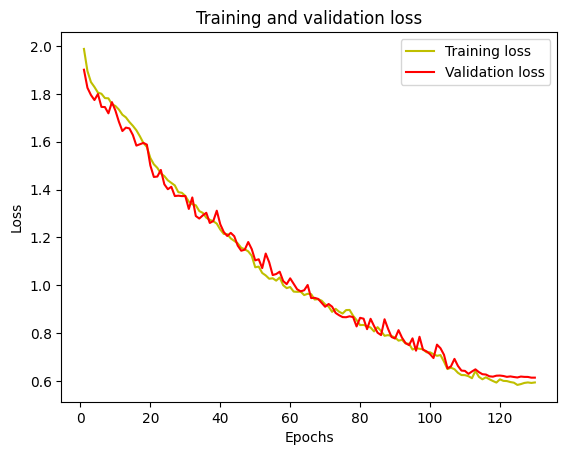

In [46]:
# Loss Plot for LSTM Model

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

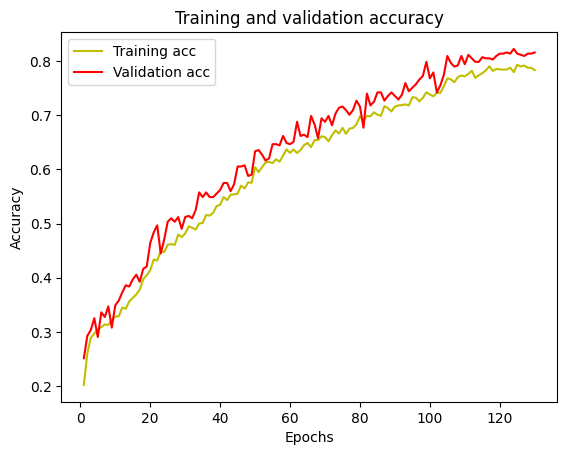

In [47]:
# Accuracy Plots using LSTM Model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

✅ Model Accuracy on Test Set: 86.63%

📋 Classification Report:
              precision    recall  f1-score   support

     neutral       0.92      0.87      0.89        38
        calm       0.93      0.91      0.92        76
       happy       0.74      0.79      0.76        75
         sad       0.90      0.86      0.88        77
       angry       0.89      0.83      0.86        78
     fearful       0.91      0.92      0.92        77
     disgust       0.79      0.90      0.84        78
   surprised       0.90      0.86      0.88        77

    accuracy                           0.87       576
   macro avg       0.87      0.87      0.87       576
weighted avg       0.87      0.87      0.87       576



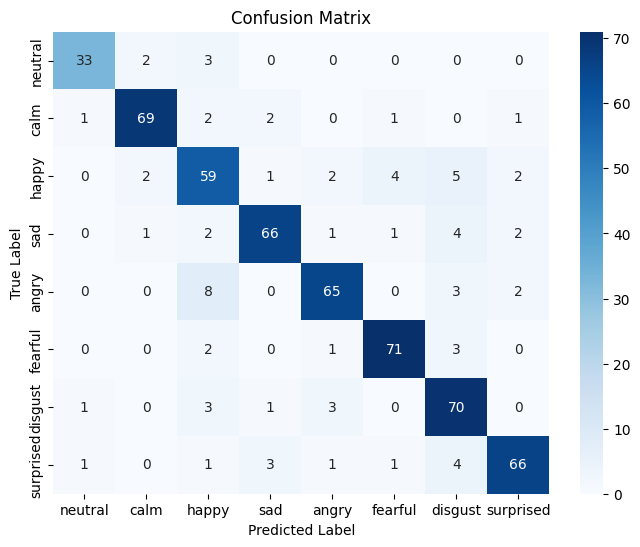

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the mapping of labels to emotion names
emotions = {
    0: "neutral", 1: "calm", 2: "happy", 3: "sad",
    4: "angry", 5: "fearful", 6: "disgust", 7: "surprised"
}

# ✅ Correct the test input shape
x_test_eval = np.expand_dims(radvess_speech_data_array[training_samples+validation_samples:], -1)
x_test_eval = np.repeat(x_test_eval, 2, axis=-1)

# Get model predictions on the test set
y_pred = model_A.predict(x_test_eval)

# Convert predictions and actual labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_categorical[training_samples+validation_samples:], axis=1)

# Compute accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\n✅ Model Accuracy on Test Set: {accuracy * 100:.2f}%")

# Print classification report
print("\n📋 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotions.values()))

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions.values(), yticklabels=emotions.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [82]:
def predict(wav_filepath):
    test_point = extract_mfcc(wav_filepath)
    test_point = np.array(test_point).reshape(1, -1)

    # Normalize using the same scaler
    test_point = scaler.transform(test_point)

    # Reshape to match model input shape (1, 40, 2)
    test_point = np.expand_dims(test_point, -1)
    test_point = np.repeat(test_point, 2, axis=-1)

    # Predict
    predictions = model_A.predict(test_point)
    predicted_label = np.argmax(predictions[0])
    predicted_emotion = emotions[predicted_label]

    print(f"🧠 Predicted Emotion: {predicted_emotion}")


In [97]:
predict('/content/ravdess/Actor_12/03-01-08-01-02-01-12.wav')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🧠 Predicted Emotion: surprised


In [98]:
# Saving Model for Use in Streamlit Application

model_A.save('emotionrecognition.h5')
print("Model successfully saved as 'emotionrecognition.h5'!")

Model successfully saved as 'emotionrecognition.h5'!
